# Objective:
- Explain which features drive churn predictions globally.
- Understand segment-level drivers of churn.
- Provide per-customer explanations for targeted retention strategies.
- Make the model **actionable and interpretable** for business stakeholders.


In [1]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [2]:
import shap
import xgboost as xgb
import pandas as pd

# Load final dataset
data = pd.read_csv(
    r"C:\Users\zoraw\Desktop\Agentic Customer Segmentatio\data_final_for_modeling.csv"
)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Split features & target
X = data.drop(columns=['customerID', 'Churn'])
y = data['Churn']
X_encoded = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Load previously trained XGBoost model
# (If not saved, retrain quickly using Phase 4 optimized parameters)
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.85
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [3]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)


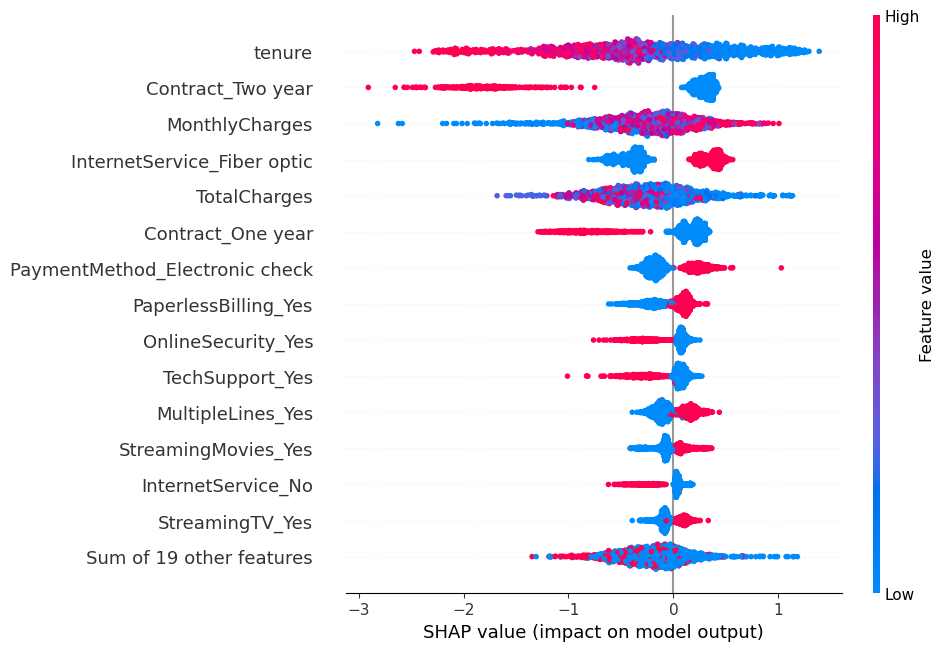

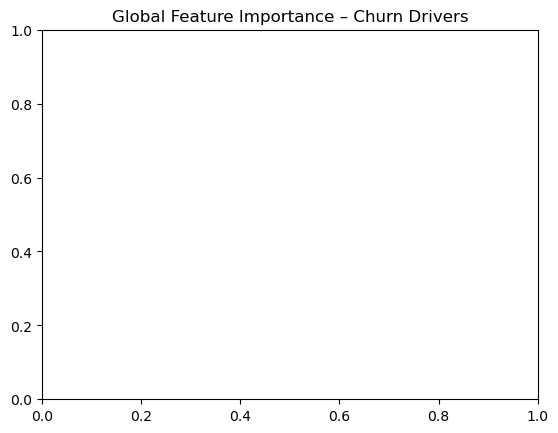

In [4]:
import matplotlib.pyplot as plt

shap.plots.beeswarm(shap_values, max_display=15)
plt.title("Global Feature Importance – Churn Drivers")
plt.show()


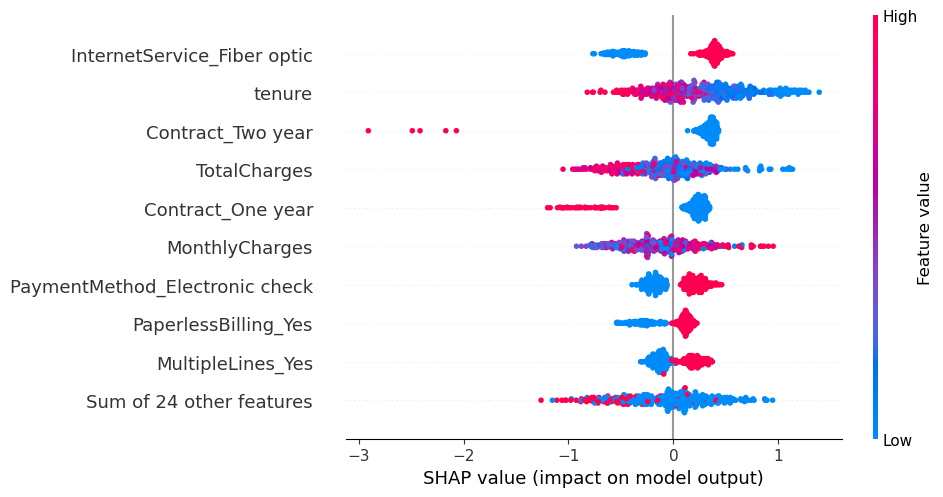

In [5]:
# Add Segment_Label back to test set
X_test_with_segments = X_test.copy()
X_test_with_segments['Segment_Label'] = data.loc[X_test.index, 'Segment_Label']

# Pick a segment that exists
segment = 'New High Spend (At Risk)'  # Use exact label
segment_mask = X_test_with_segments['Segment_Label'] == segment

# Slice SHAP values correctly
shap_values_segment = shap_values[segment_mask.values]

# Plot SHAP for this segment
shap.plots.beeswarm(shap_values_segment, max_display=10)


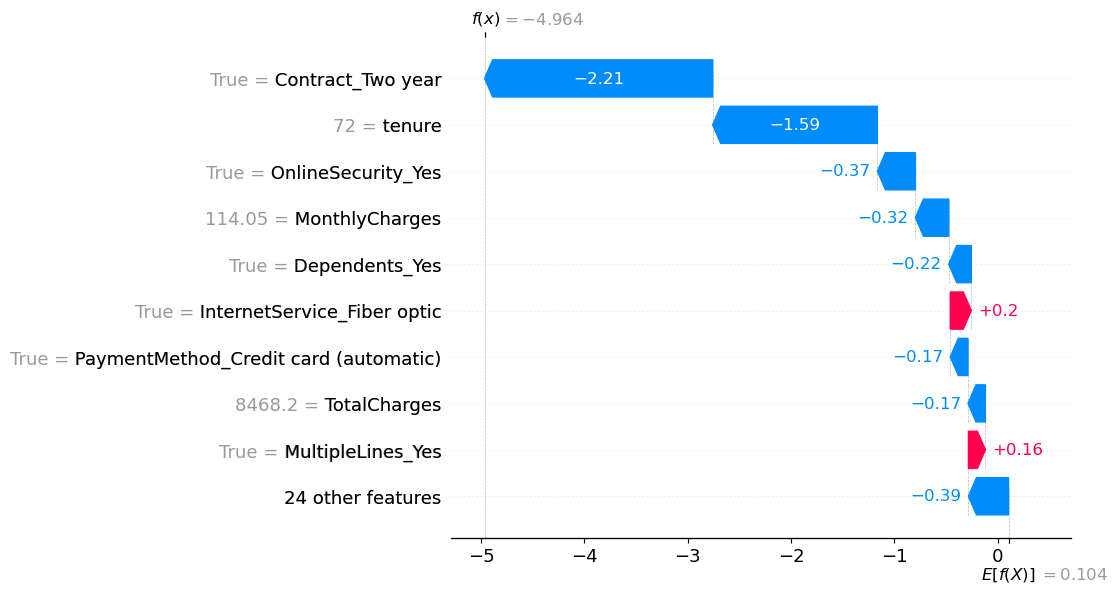

In [6]:
# Pick one customer
customer_idx = 0
shap.plots.waterfall(shap_values[customer_idx])


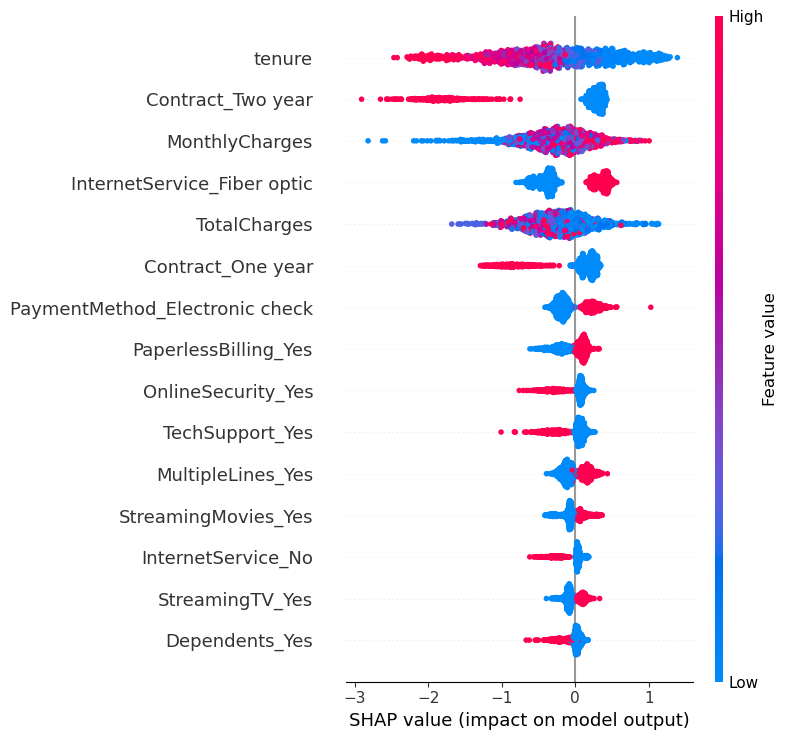

In [7]:
shap.summary_plot(shap_values, X_test, max_display=15)


### SHAP Insights for Churn

1. **Global Drivers:**  
   - Short tenure, Month-to-Month contracts, high monthly charges, and certain segments are strongest churn drivers.

2. **Segment Insights:**  
   - High-value “At Risk” segment churn is influenced mostly by contract type and online service usage.  
   - Low-value segment churn is driven by tenure and MonthlyCharges.

3. **Individual Insights:**  
   - Each customer can be explained with a SHAP waterfall, enabling **targeted retention actions**.

4. **Business Impact:**  
   - Marketing can now target campaigns **per segment** with high ROI.  
   - Product teams can identify **features causing churn**.
